In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


# Dataset

In [ ]:
imgs = os.listdir('/input/working/images')
imgs_train, imgs_val = train_test_split(imgs, test_size=0.05)

df = pd.read_csv('../input/car-plate-get-annotation-info-from-xml/annotation.csv')

In [ ]:
import yaml
cwd = '/kaggle/working/'
data = dict(
    train =  cwd + 'train.txt',
    val   =  cwd + 'val.txt',
    nc    = 1,
    names = ['licence'],
)

with open(cwd + 'bgr.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)
with open(cwd + 'train.txt', 'w') as f:
    for path in imgs_train:
        f.write(cwd+'images/'+path+'\n')
with open(cwd + 'val.txt', 'w') as f:
    for path in imgs_val:
        f.write(cwd+'images/'+path+'\n')

In [ ]:
for file in imgs:
    file = file.split('.')[0]
    bboxs = []
    for _,row in df[df['file'] == file].iterrows():
        bbox = [str(0), str(row['Xcent']), str(row['Ycent']), str(row['boxW']), str(row['boxH'])]
        bbox = ' '.join(bbox)
        bboxs.append(bbox)
    with open(cwd+'labels/'+file+'.txt', 'w') as f:
        bboxs = '\n'.join(bboxs)
        f.write(bboxs)

# YOLOv5

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

from yolov5 import utils
display = utils.notebook_init()

YOLOv5 🚀 v6.0-218-g7539cd7 torch 1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)


Setup complete ✅ (2 CPUs, 15.6 GB RAM, 3160.6/4030.7 GB disk)


In [ ]:
!pip install -q wandb --upgrade

import wandb
wandb.login(anonymous='must')

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Train

In [ ]:
!python train.py --img 1280\
--batch 10\
--epochs 50\
--data /kaggle/working/bgr.yaml\
--weights yolov5m6.pt

wandb: Currently logged in as: anony-mouse-193486 (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.12.9
wandb: Syncing run wild-gorge-1
wandb: ⭐️ View project at https://wandb.ai/anony-mouse-193486/YOLOv5?apiKey=6535645a395653414c0392145117377f8bc596ce
wandb: 🚀 View run at https://wandb.ai/anony-mouse-193486/YOLOv5/runs/3ksl8xnf?apiKey=6535645a395653414c0392145117377f8bc596ce
wandb: Run data is saved locally in /kaggle/working/yolov5/wandb/run-20220129_183120-3ksl8xnf
wandb: Run `wandb offline` to turn off syncing.
wandb: WARNING Do NOT share these links with anyone. They can be used to claim your runs.













































































































wandb: Waiting for W&B process to finish, PID 145... (success).
wandb:                                                                                
wandb: Run history:
wandb:        metrics/mAP_0.5 ▁▂▅▄▆▅▇▇▆█▇▇██▇████▇████████████████████

# Visualize

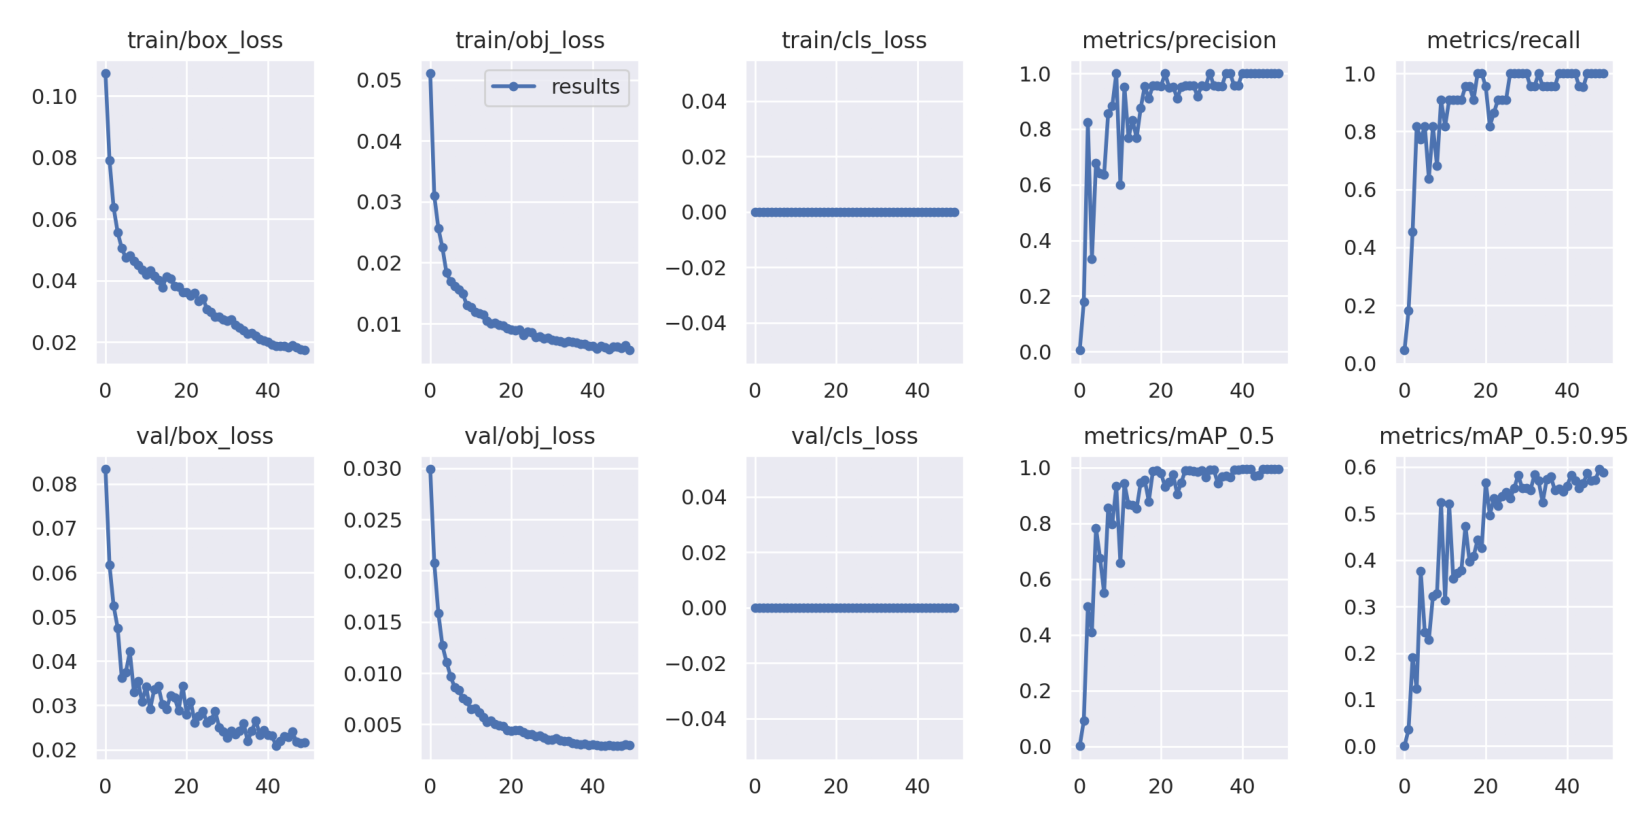

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread('/kaggle/working/yolov5/runs/train/exp/results.png'))

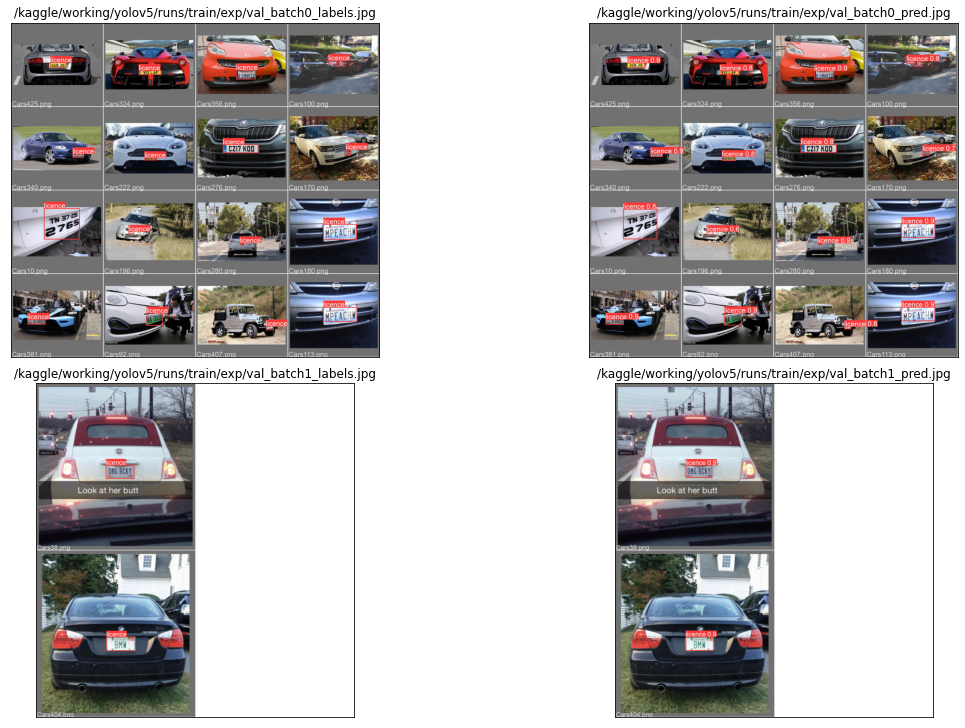

In [ ]:
fig, ax = plt.subplots(2, 2, figsize = (2*8,2*5), constrained_layout = True)
for row in range(2):
    ax[row][0].imshow(plt.imread(f'/kaggle/working/yolov5/runs/train/exp/val_batch{row}_labels.jpg'))
    ax[row][0].set_xticks([])
    ax[row][0].set_yticks([])
    ax[row][0].set_title(f'/kaggle/working/yolov5/runs/train/exp/val_batch{row}_labels.jpg', fontsize = 12)
    
    ax[row][1].imshow(plt.imread(f'/kaggle/working/yolov5/runs/train/exp/val_batch{row}_pred.jpg'))
    ax[row][1].set_xticks([])
    ax[row][1].set_yticks([])
    ax[row][1].set_title(f'/kaggle/working/yolov5/runs/train/exp/val_batch{row}_pred.jpg', fontsize = 12)
plt.show()

# Predict

In [ ]:
import torch
from PIL import Image

CKPT_PATH = '/kaggle/working/yolov5/runs/train/exp/weights/best.pt'
yolov5 = torch.hub.load('/kaggle/working/yolov5',
                        'custom',
                        path=CKPT_PATH,
                        source='local',
                        force_reload=True)

'confidence: ' + str(yolov5.conf)

YOLOv5 🚀 v6.0-218-g7539cd7 torch 1.9.1 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 378 layers, 35248920 parameters, 0 gradients, 49.0 GFLOPs
Adding AutoShape... 


'confidence: 0.25'

In [ ]:
imgs = os.listdir('/kaggle/input/car-plate-detection/images')

pred_df = pd.DataFrame()
for pth in imgs:
    img = Image.open('/kaggle/input/car-plate-detection/images/' + pth).convert('RGB')
    img = np.asarray(img)
    pred = yolov5(img, size=1280, augment=False)
    for i, row in pred.pandas().xyxy[0].iterrows():
        if row['confidence'] < yolov5.conf: break
        row['path'] = pth
        pred_df = pred_df.append(row)
pred_df = pred_df.reset_index()

In [ ]:
pred_df

,index,xmin,ymin,xmax,ymax,confidence,class,name,path
0,0,91.403198,167.426376,215.376266,210.155029,0.843391,0.0,licence,Cars393.png
1,0,158.276306,178.173004,250.783295,201.024033,0.891881,0.0,licence,Cars376.png
2,0,3.157363,203.314789,45.706161,222.255554,0.889912,0.0,licence,Cars87.png
3,1,345.423645,168.584686,364.584503,175.412735,0.789451,0.0,licence,Cars87.png
4,0,148.481766,210.246429,247.427185,236.215286,0.894458,0.0,licence,Cars190.png
...,...,...,...,...,...,...,...,...,...
497,0,148.239120,205.289230,282.947876,239.877701,0.858362,0.0,licence,Cars382.png
498,0,5.521957,117.969841,463.179688,237.707840,0.388035,0.0,licence,Cars76.png
499,0,174.843445,80.693726,315.980225,121.059586,0.824024,0.0,licence,Cars272.png
500,0,152.018494,112.392960,307.029968,177.559525,0.844522,0.0,licence,Cars361.png


# OCR with pyTesseRACt

In [ ]:
import pytesseract

for i, row in pred_df.iterrows():
    img = '/kaggle/input/car-plate-detection/images/' + row['path']
    img = Image.open(img).convert('RGB')
    img = np.asarray(img)
    img_cropped = img[int(row['ymin']):int(row['ymax']), int(row['xmin']):int(row['xmax'])]
    text = pytesseract.image_to_string(img_cropped)
    pred_df.loc[i, 'text_detected'] = text

In [ ]:
pred_df

,index,xmin,ymin,xmax,ymax,confidence,class,name,path,text_detected
0,0,91.403198,167.426376,215.376266,210.155029,0.843391,0.0,licence,Cars393.png,
1,0,158.276306,178.173004,250.783295,201.024033,0.891881,0.0,licence,Cars376.png,\n
2,0,3.157363,203.314789,45.706161,222.255554,0.889912,0.0,licence,Cars87.png,\n
3,1,345.423645,168.584686,364.584503,175.412735,0.789451,0.0,licence,Cars87.png,\n
4,0,148.481766,210.246429,247.427185,236.215286,0.894458,0.0,licence,Cars190.png,KL54-A2670\n
...,...,...,...,...,...,...,...,...,...,...
497,0,148.239120,205.289230,282.947876,239.877701,0.858362,0.0,licence,Cars382.png,CRAIG\n
498,0,5.521957,117.969841,463.179688,237.707840,0.388035,0.0,licence,Cars76.png,
499,0,174.843445,80.693726,315.980225,121.059586,0.824024,0.0,licence,Cars272.png,-RX6I GDU\n
500,0,152.018494,112.392960,307.029968,177.559525,0.844522,0.0,licence,Cars361.png,WOEACHW\n
